In [72]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append("../../")
from utils.data_utils import retime
from utils.data_vis import plot_segment_parts
from scipy.optimize import curve_fit

def exponential_relaxation(x, A, tau, C):
    return A * np.exp(-x / tau) + C

In [ ]:
hdf = pd.HDFStore('../../data/data_raw.h5', mode='r')
keys = hdf.keys()
idx1 = np.nonzero(["_A_" in key and '15C' in key for key in keys])
idx2 = np.nonzero(["_A_" in key and '15oC' in key for key in keys])
df_nominal = hdf.get(keys[idx1[0][1]])
df_degraded = hdf.get(keys[idx2[0][8]])
hdf.close()

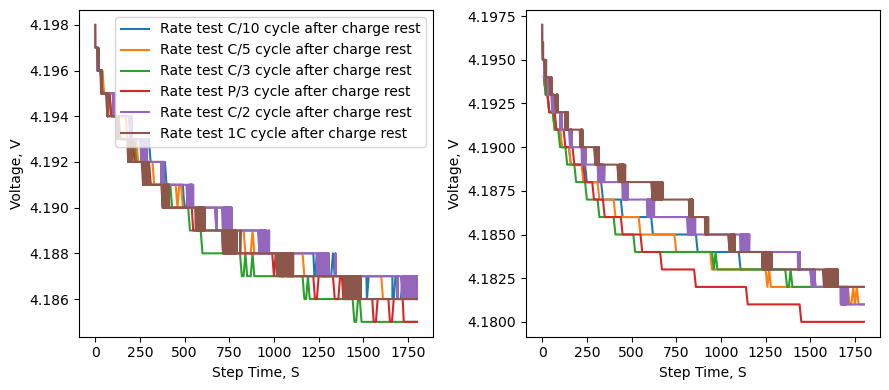

In [76]:
# Plot post-charge voltage relaxations
fig, ax = plt.subplots(1,2, figsize=(9,4))
is_cycle = ['Rate test' in seg_desc and 'after charge rest' in seg_desc in seg_desc for seg_desc in df_nominal['Segment Description']]
plot_segment_parts(ax[0], df_nominal[is_cycle], x='Step Time, S')
is_cycle = ['Rate test' in seg_desc and 'after charge rest' in seg_desc in seg_desc for seg_desc in df_degraded['Segment Description']]
plot_segment_parts(ax[1], df_degraded[is_cycle], x='Step Time, S')

ax[0].legend()
plt.tight_layout()

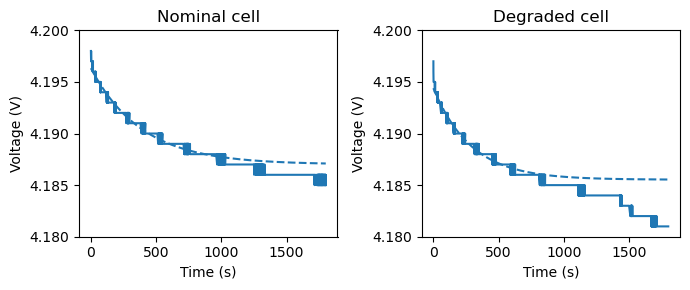

In [ ]:
hdf = pd.HDFStore('../../data/data_raw.h5', mode='r')
keys = hdf.keys()
idx1 = np.nonzero(["_A_" in key and '15C' in key for key in keys])
idx2 = np.nonzero(["_A_" in key and '15oC' in key for key in keys])
df_nominal = hdf.get(keys[idx1[0][7]])
df_degraded = hdf.get(keys[idx2[0][8]])
hdf.close()

initial_guess = (0.01, 500, 4.1)  # Initial guess for parameters (A, tau, C)
is_cycle = ['Rate test C/2 cycle after charge rest' in seg_desc for seg_desc in df_nominal['Segment Description']]
df_nominal = df_nominal.loc[is_cycle]
is_cycle = ['Rate test C/2 cycle after charge rest' in seg_desc for seg_desc in df_degraded['Segment Description']]
df_degraded = df_degraded.loc[is_cycle]

params, _ = curve_fit(
    exponential_relaxation,
    df_nominal["Step Time, S"][:500],
    df_nominal["Voltage, V"][:500],
    p0=initial_guess,
)
# Extract the fitted parameters
A_fit, tau_fit, C_fit = params
# Calculate the fitted curve using the fitted parameters
v_fit_nominal = exponential_relaxation(df_nominal["Step Time, S"], A_fit, tau_fit, C_fit)

params, _ = curve_fit(
    exponential_relaxation,
    df_degraded["Step Time, S"][:500],
    df_degraded["Voltage, V"][:500],
    p0=initial_guess,
)
# Extract the fitted parameters
A_fit, tau_fit, C_fit = params
# Calculate the fitted curve using the fitted parameters
v_fit_degraded = exponential_relaxation(df_degraded["Step Time, S"], A_fit, tau_fit, C_fit)



fig, ax = plt.subplots(1,2, figsize=(7,3))
ax[0].plot(df_nominal['Step Time, S'], df_nominal['Voltage, V'], label='Data')
ax[0].plot(df_nominal['Step Time, S'], v_fit_nominal, '--', color='tab:blue', label='Fit')

ax[1].plot(df_degraded['Step Time, S'], df_degraded['Voltage, V'])
ax[1].plot(df_degraded['Step Time, S'], v_fit_degraded, '--', color='tab:blue', label='Fit')

ax[0].set_title('Nominal cell')
ax[0].set_ylim([4.18, 4.2])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Voltage (V)')
ax[1].set_title('Degraded cell')
ax[1].set_ylim([4.18, 4.2])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Voltage (V)')
plt.tight_layout()